# 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 1. Importing  libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the  Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'r8BmPHEz9UD8DTPcU-MM'

In [3]:
# Importing the "Consumer Price Index - UK" variable.

data = quandl.get('RATEINF/CPI_GBR')

In [4]:
data.head(5)

,Value
Date,
1988-01-31,48.395
1988-02-29,48.551
1988-03-31,48.717
1988-04-30,49.280
1988-05-31,49.529


In [5]:
data.shape

(423, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

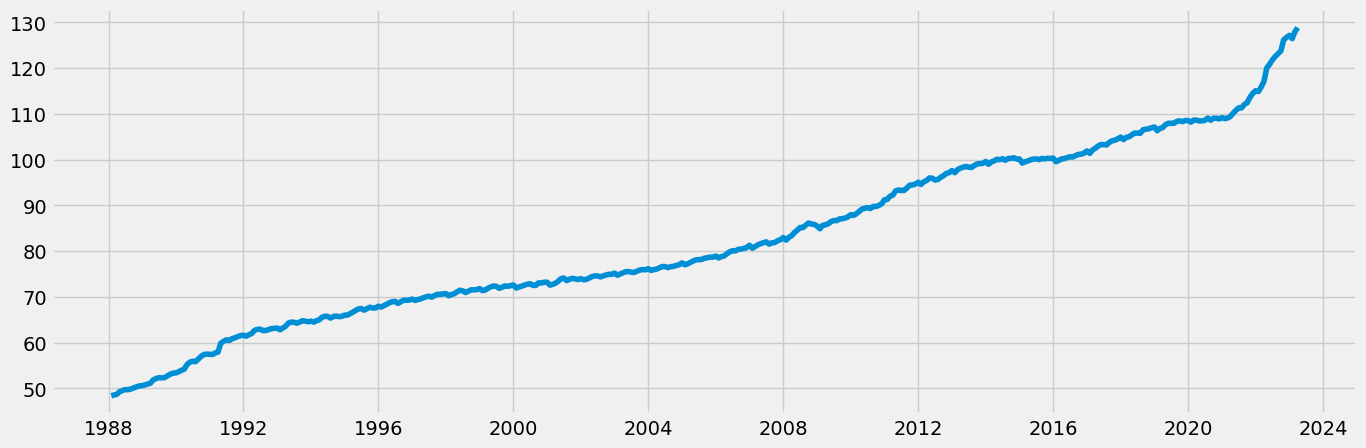

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1988-01-31,48.395
1,1988-02-29,48.551
2,1988-03-31,48.717
3,1988-04-30,49.280
4,1988-05-31,49.529


In [36]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2023-06-01')]

In [37]:
data_sub.shape

(279, 2)

In [38]:
data_sub.head()

,Date,Value
144,2000-01-31,71.936
145,2000-02-29,72.159
146,2000-03-31,72.338
147,2000-04-30,72.573
148,2000-05-31,72.771


In [39]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-31,71.936
2000-02-29,72.159
2000-03-31,72.338
2000-04-30,72.573
2000-05-31,72.771


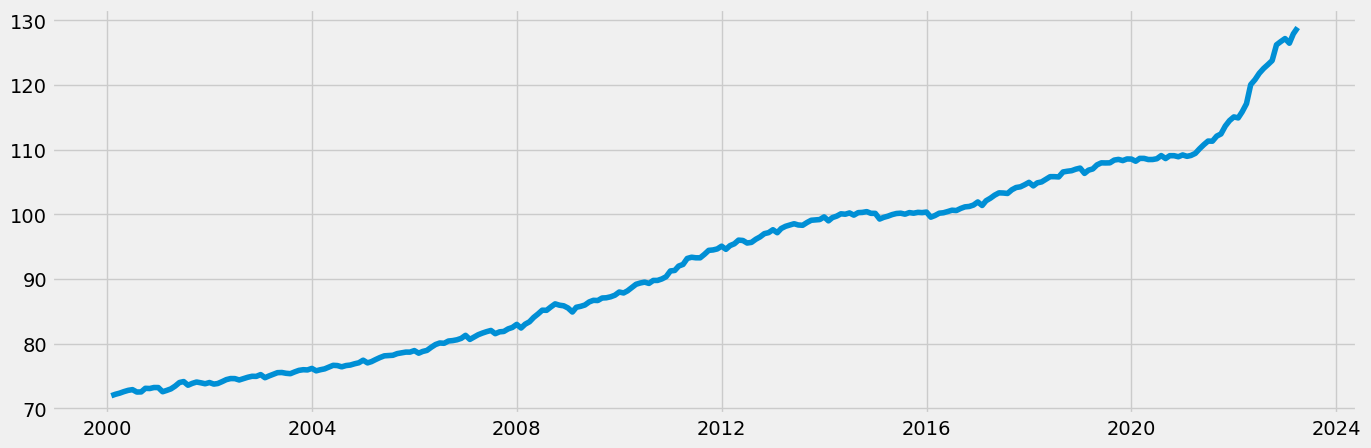

In [40]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values 
data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

### 3. Time-series analysis: decomposition

In [41]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [42]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

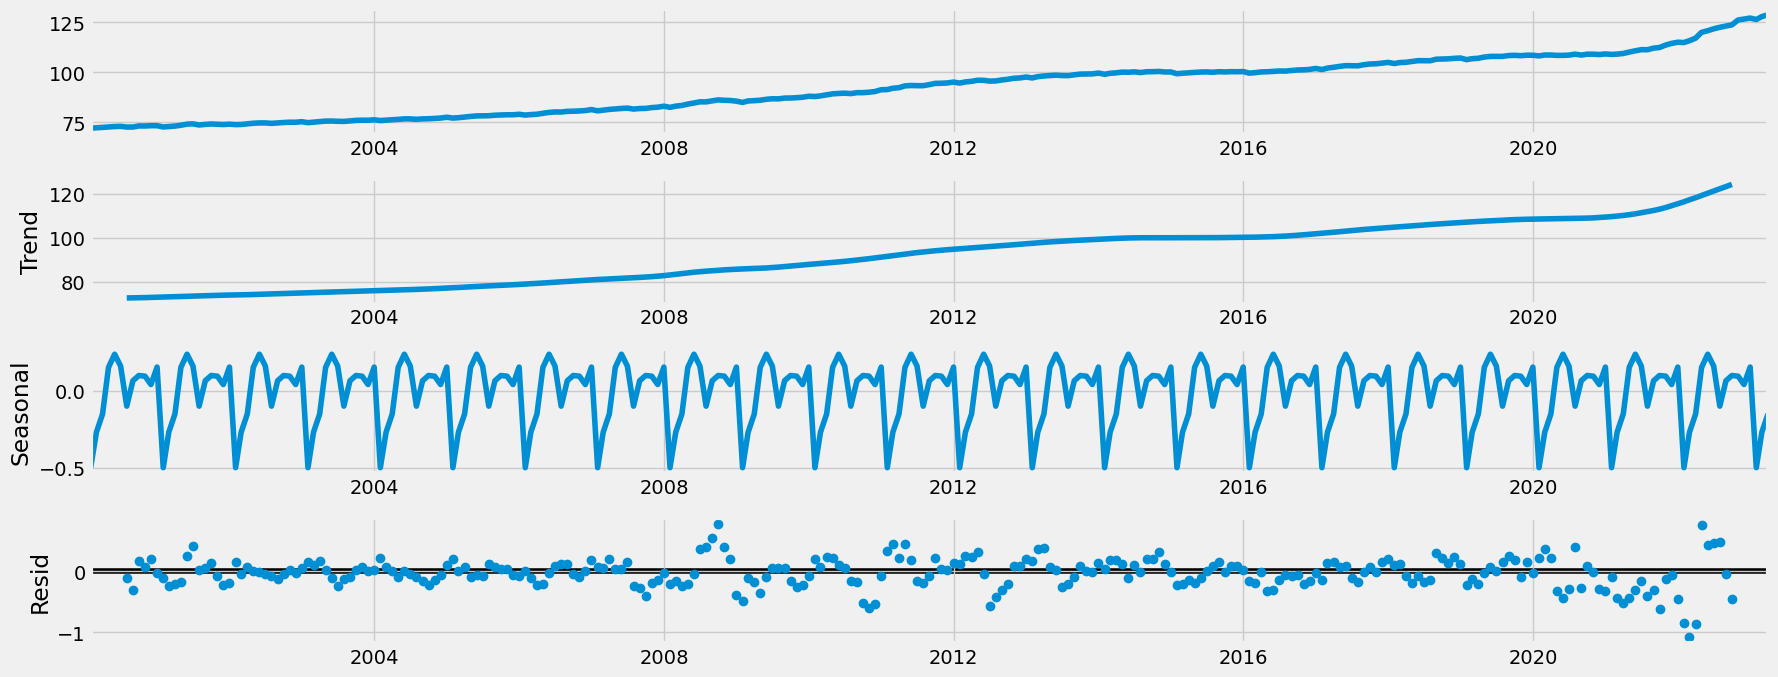

In [43]:
# Plot the separate components

decomposition.plot()
plt.show()

The trend in the chart above (Consumer price inflation in the UK) gradually increase in a linear fashion from 2000. With A small  decrease around 2016, when The United Kingdom European Union membership referendum was held, commonly referred to as the Brexit referendum. 

The overall trend continues to increase all the way until the present year. Excpet for a slight slowdown between 2020 and 2021 which coincides with the COVID-19. pandemic

### 4. Testing for stationarity

In [44]:
 # Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.295429
p-value                          0.996583
Number of Lags Used             14.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


The “Critical Value (5%)” has a value of -2.872551, which is much smaller than the test statistic, which is 1.295429. That means that we can’t reject the null hypothesis. There is a unit root in the data, so the data is non-stationary. 



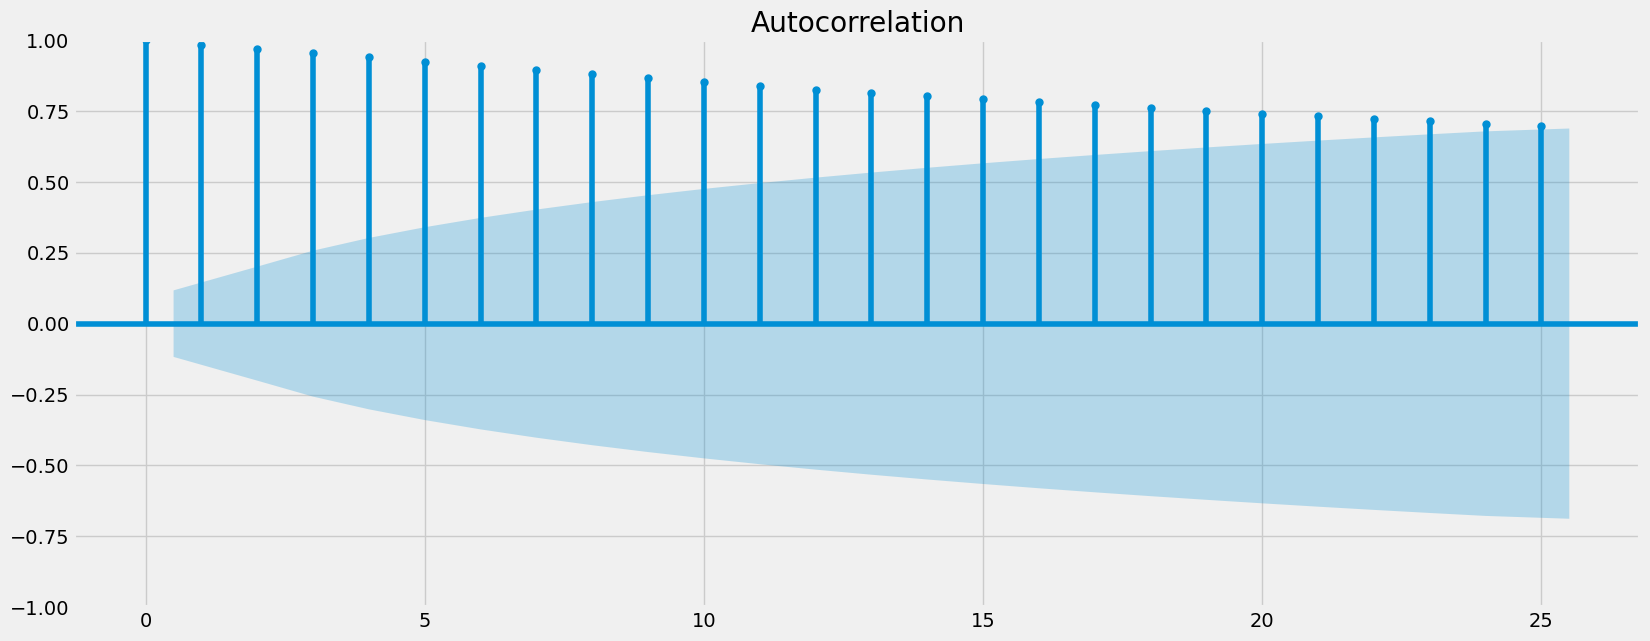

In [45]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_sub)
plt.show()

the Consumer Price Index - UK time series has almost all lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test.

 ### 5. Stationarizing the Data

In [46]:
data_diff = data_sub - data_sub.shift(1) 

In [47]:
data_diff.dropna(inplace = True)

In [48]:
data_diff.head()

,Value
datetime,
2000-02-29,0.223
2000-03-31,0.179
2000-04-30,0.235
2000-05-31,0.198
2000-06-30,0.105


In [49]:
data_diff.columns

Index(['Value'], dtype='object')

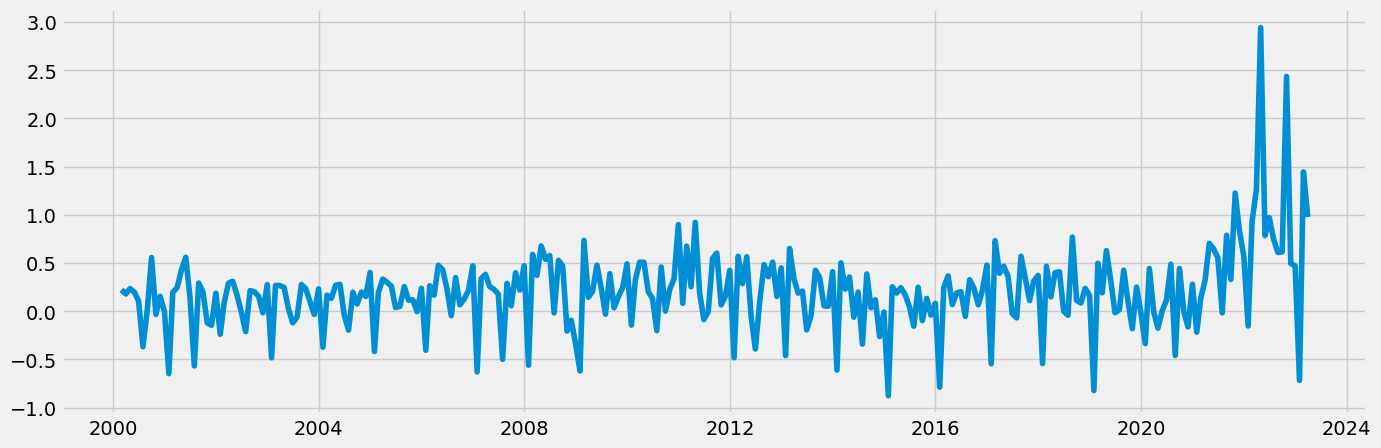

In [50]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [51]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.084532
p-value                          0.721201
Number of Lags Used             13.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


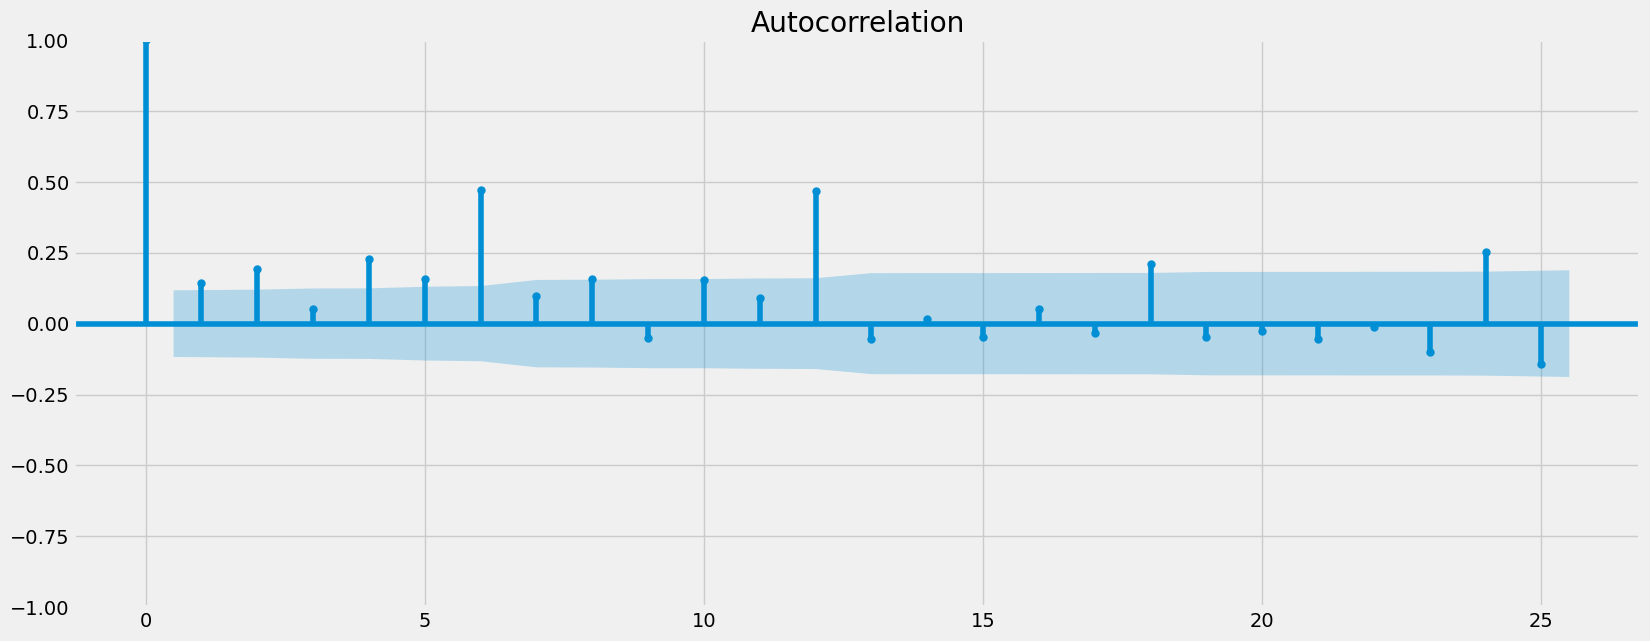

In [52]:
plot_acf(data_diff)
plt.show()

The test statistic has reduced  but its still greater than The “Critical Value (5%)”, and the P-value hasn't reduced enough. 

On the other side, the autocorrelation plot has improved (there are fewer autocorrelated terms), and the unspoken rule of thumb that you need at least ten significant lags (which here is 9) we dont need to do a second round of differencing. 